# Resume Scoring Model Development Notebook (Updated for New Dataset)

**Dataset Structure:**
- Resume_ID: Unique ID
- Name: Candidate name
- Skills: Skills list
- Experience (Years): Years of experience
- Education: Education level
- Certifications: Certifications (some missing)
- Job Role: Target job role
- Recruiter Decision: Hiring decision
- Salary Expectation ($): Expected salary
- Projects Count: Number of projects
- AI Score (0-100): Target variable

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import joblib

c:\Users\ASUS\Downloads\MBKM DataIns\RAG CV\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset
df = pd.read_csv('C:/Users/ASUS/Downloads/MBKM DataIns/RAG CV/models/AI_Resume_Screening.csv')

# EDA

In [3]:
# Initialize NLTK
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Set style visualisasi
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [5]:
# Basic info
print("Dataset Info:")
print(f"Shape: {df.shape}")
print("\nColumns and Non-Null Counts:")
print(df.info())
print("\nSample Data:")
df.head(3)

Dataset Info:
Shape: (1000, 11)

Columns and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Resume_ID               1000 non-null   int64 
 1   Name                    1000 non-null   object
 2   Skills                  1000 non-null   object
 3   Experience (Years)      1000 non-null   int64 
 4   Education               1000 non-null   object
 5   Certifications          726 non-null    object
 6   Job Role                1000 non-null   object
 7   Recruiter Decision      1000 non-null   object
 8   Salary Expectation ($)  1000 non-null   int64 
 9   Projects Count          1000 non-null   int64 
 10  AI Score (0-100)        1000 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 86.1+ KB
None

Sample Data:


,Resume_ID,Name,Skills,Experience (Years),Education,Certifications,Job Role,Recruiter Decision,Salary Expectation ($),Projects Count,AI Score (0-100)
0,1,Ashley Ali,"TensorFlow, NLP, Pytorch",10,B.Sc,NaN,AI Researcher,Hire,104895,8,100
1,2,Wesley Roman,"Deep Learning, Machine Learning, Python, SQL",10,MBA,Google ML,Data Scientist,Hire,113002,1,100
2,3,Corey Sanchez,"Ethical Hacking, Cybersecurity, Linux",1,MBA,Deep Learning Specialization,Cybersecurity Analyst,Hire,71766,7,70


In [6]:
# Missing values analysis
print("\nMissing Values Analysis:")
print(df.isnull().sum()[df.isnull().sum() > 0])


Missing Values Analysis:
Certifications    274
dtype: int64


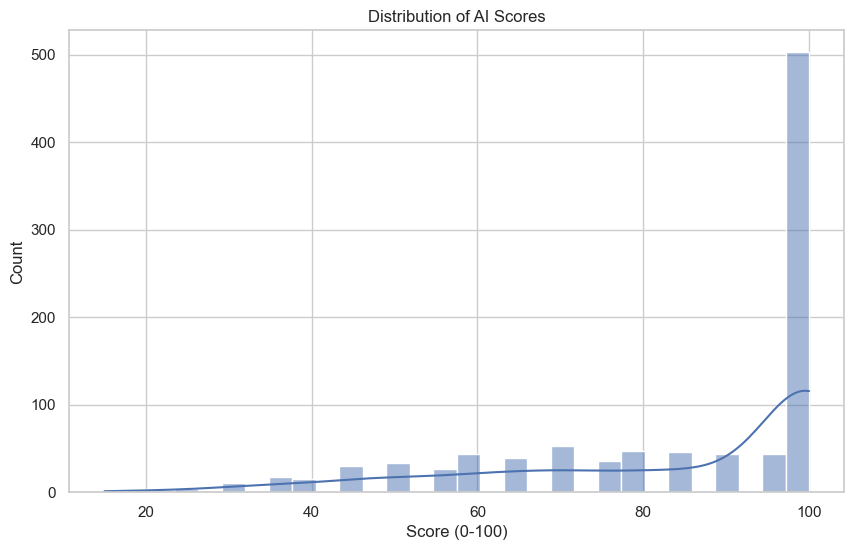

In [7]:
# Target distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['AI Score (0-100)'], bins=30, kde=True)
plt.title('Distribution of AI Scores')
plt.xlabel('Score (0-100)')
plt.ylabel('Count')
plt.show()

In [8]:
# Numerical features analysis
num_cols = ['Experience (Years)', 'Salary Expectation ($)', 'Projects Count']
df[num_cols].describe()

,Experience (Years),Salary Expectation ($),Projects Count
count,1000.000000,1000.000000,1000.00000
mean,4.896000,79994.486000,5.13300
std,3.112695,23048.472549,3.23137
min,0.000000,40085.000000,0.00000
25%,2.000000,60415.750000,2.00000
50%,5.000000,79834.500000,5.00000
75%,8.000000,99583.250000,8.00000
max,10.000000,119901.000000,10.00000



Education Value Counts:
Education
B.Sc      205
MBA       202
B.Tech    200
M.Tech    198
PhD       195
Name: count, dtype: int64


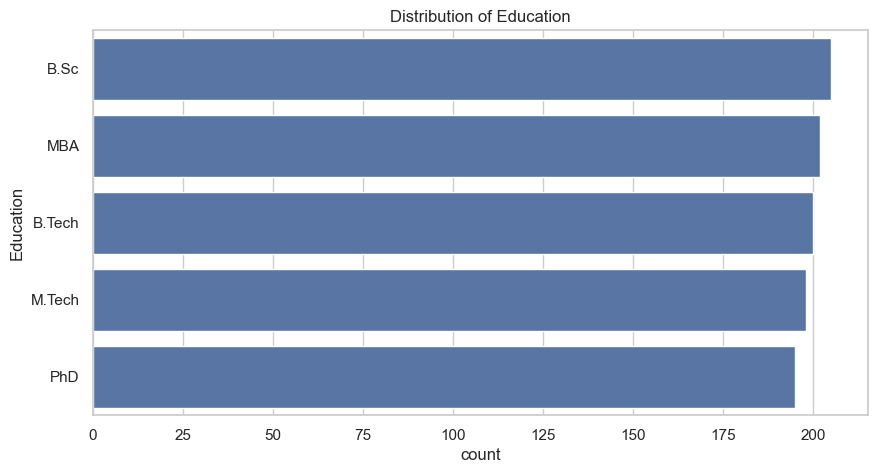


Job Role Value Counts:
Job Role
AI Researcher            257
Data Scientist           255
Cybersecurity Analyst    255
Software Engineer        233
Name: count, dtype: int64


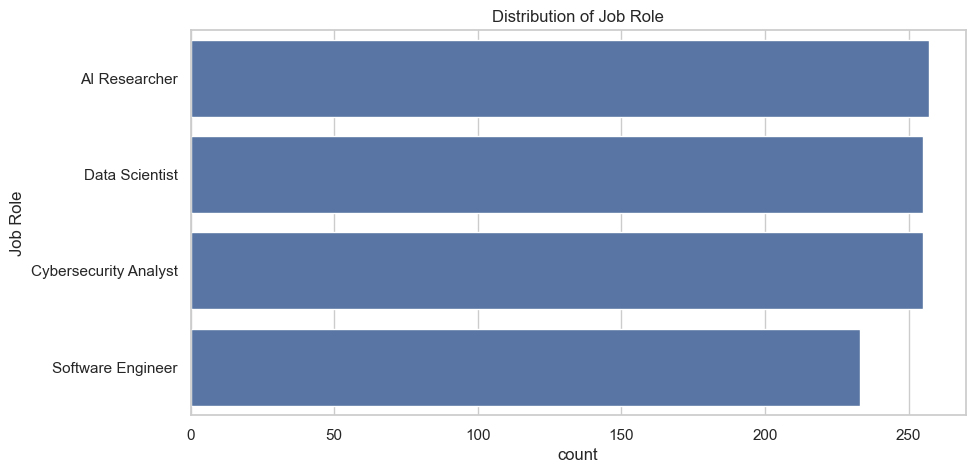


Recruiter Decision Value Counts:
Recruiter Decision
Hire      812
Reject    188
Name: count, dtype: int64


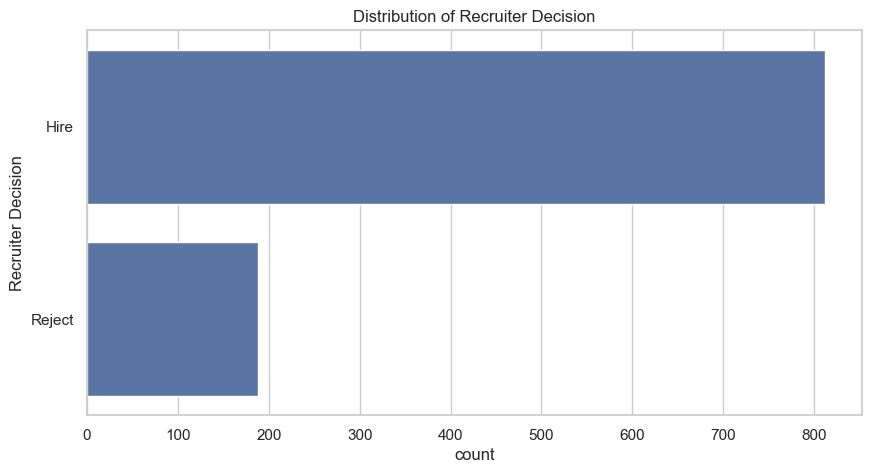

In [9]:
# Categorical features analysis
cat_cols = ['Education', 'Job Role', 'Recruiter Decision']

for col in cat_cols:
    print(f"\n{col} Value Counts:")
    print(df[col].value_counts())
    
    plt.figure(figsize=(10, 5))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.show()

In [10]:
# Skills analysis (example of processing list-like data)
df['Skills_Count'] = df['Skills'].apply(lambda x: len(x.split(',')))
print("\nSkills Count Statistics:")
print(df['Skills_Count'].describe())


Skills Count Statistics:
count    1000.000000
mean        3.017000
std         0.805829
min         2.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: Skills_Count, dtype: float64


# Preprocesing

In [11]:
def clean_text(text):
    """Clean and standardize text data"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special chars
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

In [12]:
def preprocess_data(df):
    """Main preprocessing function"""
    # Clean text columns
    text_cols = ['Skills', 'Education', 'Certifications', 'Job Role']
    for col in text_cols:
        df[col] = df[col].apply(clean_text)
    
    # Handle missing certifications
    df['Certifications'] = df['Certifications'].fillna('none')
    df['Certifications_Count'] = df['Certifications'].apply(
        lambda x: 0 if x == 'none' else len(x.split(',')))
    
    # Create combined text feature
    df['Combined_Text'] = (
        "Skills: " + df['Skills'] + 
        " | Education: " + df['Education'] + 
        " | Certifications: " + df['Certifications'] + 
        " | Job Role: " + df['Job Role']
    )
    
    # Convert recruiter decision to binary (for potential use)
    df['Hired'] = df['Recruiter Decision'].apply(
        lambda x: 1 if x.lower() in ['hired', 'selected'] else 0)
    
    return df

In [13]:
# Apply preprocessing
processed_df = preprocess_data(df.copy())

# Show processed features
print("\nProcessed Features:")
processed_df[['Skills_Count', 'Certifications_Count', 'Combined_Text', 'Hired']].head(3)


Processed Features:


,Skills_Count,Certifications_Count,Combined_Text,Hired
0,3,1,Skills: tensorflow nlp pytorch | Education: bs...,0
1,4,1,Skills: deep learning machine learning python ...,0
2,3,1,Skills: ethical hacking cybersecurity linux | ...,0


In [14]:
# Prepare features and target
numerical_features = processed_df[[
    'Experience (Years)', 
    'Salary Expectation ($)', 
    'Projects Count',
    'Skills_Count',
    'Certifications_Count'
]]

target = processed_df['AI Score (0-100)']

In [15]:
# Normalize numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features,
    target,
    test_size=0.2,
    random_state=42
)

print(f"\nData Splits:")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Data Splits:
Train: (800, 5), Test: (200, 5)


# Pemodelan

In [16]:
# Konfigurasi model
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [21]:
class ResumeDataset(Dataset):
    def __init__(self, texts, numerical_features, scores):
        self.texts = texts
        self.numerical = numerical_features
        self.scores = scores
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=256,  # Reduced from 512 for efficiency
            return_tensors="pt"
        )
        
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'numerical': torch.FloatTensor(self.numerical[idx]),
            'score': torch.FloatTensor([self.scores[idx]])
        }

In [22]:
# Model Architecture
class ResumeScoringModel(nn.Module):
    def __init__(self, n_numerical_features):
        super().__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.text_fc = nn.Linear(768, 64)
        self.num_fc = nn.Linear(n_numerical_features, 32)
        self.combined_fc = nn.Linear(64 + 32, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, input_ids, attention_mask, numerical):
        # Text features
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state.mean(dim=1)
        text_features = self.text_fc(pooled_output)
        
        # Numerical features
        num_features = self.num_fc(numerical)
        
        # Combine features
        combined = torch.cat([text_features, num_features], dim=1)
        combined = self.dropout(combined)
        score = self.combined_fc(combined)
        
        return score

In [23]:
# Siapkan DataLoader
train_texts = processed_df.iloc[y_train.index, :]['Combined_Text'].values
test_texts = processed_df.iloc[y_test.index, :]['Combined_Text'].values

train_dataset = ResumeDataset(train_texts, X_train, y_train.values)
test_dataset = ResumeDataset(test_texts, X_test, y_test.values)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [24]:
# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResumeScoringModel(n_numerical_features=X_train.shape[1]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

In [25]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        numerical = batch['numerical'].to(device)
        scores = batch['score'].to(device)
        
        outputs = model(input_ids, attention_mask, numerical)
        loss = criterion(outputs, scores)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            numerical = batch['numerical'].to(device)
            scores = batch['score'].to(device)
            
            outputs = model(input_ids, attention_mask, numerical)
            loss = criterion(outputs, scores)
            
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [26]:
# Jalankan Training
NUM_EPOCHS = 3
best_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "../models/resume_scoring/best_model.pt")
        print("Best model saved!")

Training:   6%|▌         | 3/50 [03:02<47:36, 60.77s/it]


KeyboardInterrupt: 

In [ ]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluasi

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def predict(model, dataloader):
    model.eval()
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            numerical = batch['numerical'].to(device)
            scores = batch['score'].to(device)
            
            outputs = model(input_ids, attention_mask, numerical)
            
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_true.extend(scores.cpu().numpy().flatten())
    
    return all_preds, all_true

In [ ]:
# Load best model and predict
model.load_state_dict(torch.load("../models/resume_scoring/best_model.pt"))
predictions, true_values = predict(model, test_loader)

In [ ]:
# Hitung metrik
mae = mean_absolute_error(true_values, predictions)
mse = mean_squared_error(true_values, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(true_values, predictions)

print("\nEvaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

In [ ]:
# Visualisasi prediksi vs aktual
plt.figure(figsize=(10, 10))
plt.scatter(true_values, predictions, alpha=0.5)
plt.plot([0, 100], [0, 100], 'r--')  # Perfect prediction line
plt.xlabel('True Scores')
plt.ylabel('Predicted Scores')
plt.title('True vs Predicted Scores')
plt.show()

In [ ]:
# Feature importance analysis (example with numerical features)
feature_importance = pd.DataFrame({
    'Feature': numerical_features.columns,
    'Importance': np.abs(model.num_fc.weight[0].detach().cpu().numpy())
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Numerical Features)')
plt.show()

# Save Model

In [ ]:
import joblib
import os

# Buat direktori jika belum ada
os.makedirs("../models/resume_scoring", exist_ok=True)
os.makedirs("../models/preprocessing", exist_ok=True)

# Simpan model dan preprocessing artifacts
torch.save(model.state_dict(), "../models/resume_scoring/best_model.pt")
joblib.dump(scaler, "../models/preprocessing/scaler.joblib")
tokenizer.save_pretrained("../models/preprocessing/tokenizer")

In [ ]:
# Simpan config
model_config = {
    "model_name": MODEL_NAME,
    "numerical_features": list(numerical_features.columns),
    "text_features": "Combined_Text",
    "target_range": [0, 100],
    "input_length": 256
}

import json
with open("../models/resume_scoring/config.json", "w") as f:
    json.dump(model_config, f)

print("\nModel dan artifacts berhasil disimpan!")